In [1]:
import pandas as pd
import numpy as np
import datetime as dt
from tqdm.notebook import tqdm_notebook
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score
from lightgbm import LGBMClassifier
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')
from catboost import CatBoostClassifier
from catboost import CatBoostRegressor
import xgboost as xgb


In [3]:
train = pd.read_csv('Train_Ins.csv')
test = pd.read_csv('Test_Ins.csv')
sub = pd.read_csv('SampleSubmission.csv')

In [4]:
train.shape, test.shape

((12079, 14), (1202, 13))

In [5]:
test.head()

,ID,Policy Start Date,Policy End Date,Gender,Age,First Transaction Date,No_Pol,Car_Category,Subject_Car_Colour,Subject_Car_Make,LGA_Name,State,ProductName
0,ID_01QM0NU,2010-10-23,2011-10-22,Female,46,2010-10-23,1,NaN,NaN,Ford,Abuja Municipal,Abuja-Municipal,Car Classic
1,ID_024NJLZ,2010-10-14,2011-10-13,Male,32,2010-10-14,1,NaN,NaN,NaN,Kosofe,Benue,Car Classic
2,ID_02NOVWQ,2010-08-29,2011-08-28,Female,45,2010-08-29,2,Saloon,Black,Honda,Wuse 11,Abuja,Car Classic
3,ID_02VSP68,2010-06-13,2011-06-12,Female,58,2010-06-13,1,Saloon,NaN,TOYOTA,NaN,NaN,CarSafe
4,ID_02YB37K,2010-07-01,2011-06-30,NaN,120,2010-07-01,1,Saloon,Red,Hyundai,Victoria Island,Lagos,Car Classic


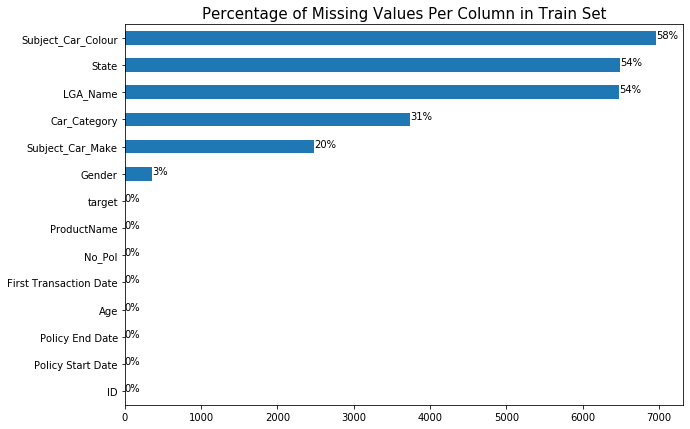

In [6]:
ax = train.isna().sum().sort_values().plot(kind = 'barh', figsize = (10, 7))
plt.title('Percentage of Missing Values Per Column in Train Set', fontdict={'size':15})
for p in ax.patches:
    percentage ='{:,.0f}%'.format((p.get_width()/train.shape[0])*100)
    width, height =p.get_width(),p.get_height()
    x=p.get_x()+width+0.02
    y=p.get_y()+height/2
    ax.annotate(percentage,(x,y))

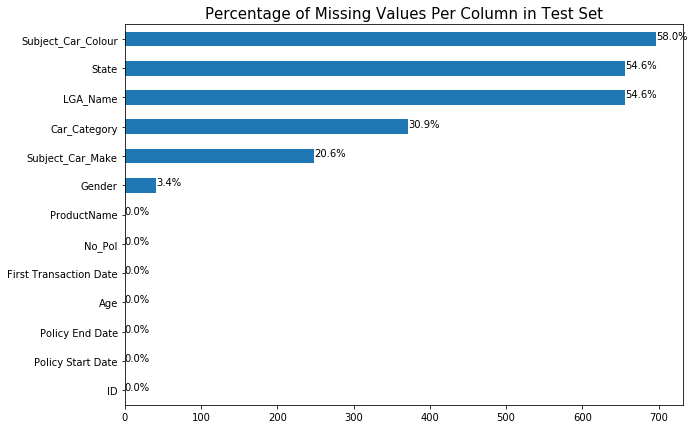

In [7]:
# Check if there missing values in test set
ax = test.isna().sum().sort_values().plot(kind = 'barh', figsize = (10, 7))
plt.title('Percentage of Missing Values Per Column in Test Set', fontdict={'size':15})

for p in ax.patches:
    percentage ='{:,.1f}%'.format((p.get_width()/test.shape[0])*100)
    width, height =p.get_width(),p.get_height()
    x=p.get_x()+width+0.02
    y=p.get_y()+height/2
    ax.annotate(percentage,(x,y))

In [27]:
ntrain = train.shape[0] # to be used to split train and test set from the combined dataframe

all_data = pd.concat((train, test)).reset_index(drop=True)
print(f'The shape of the combined dataframe is: {all_data.shape}')

The shape of the combined dataframe is: (13281, 14)


In [28]:
# Change each column to its appriopriate datatype
date_cols = [col for col in all_data.columns if 'Date' in col]
num_cols = ['Age', 'No_Pol']
cat_cols = [col for col in all_data.columns if col not in date_cols+num_cols+['ID', 'target']]

for col in all_data.columns:
  if col in date_cols:
    all_data[col] = pd.to_datetime(all_data[col])
  elif col in cat_cols:
    all_data[col] = all_data[col].astype('category')

# Confirm whether the changes have been applied successfully
all_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13281 entries, 0 to 13280
Data columns (total 14 columns):
Age                       13281 non-null int64
Car_Category              9171 non-null category
First Transaction Date    13281 non-null datetime64[ns]
Gender                    12881 non-null category
ID                        13281 non-null object
LGA_Name                  6149 non-null category
No_Pol                    13281 non-null int64
Policy End Date           13281 non-null datetime64[ns]
Policy Start Date         13281 non-null datetime64[ns]
ProductName               13281 non-null category
State                     6137 non-null category
Subject_Car_Colour        5622 non-null category
Subject_Car_Make          10557 non-null category
target                    12079 non-null float64
dtypes: category(7), datetime64[ns](3), float64(1), int64(2), object(1)
memory usage: 854.4+ KB


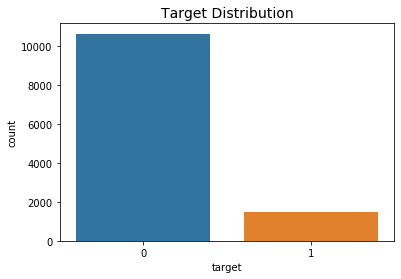

In [29]:
sns.countplot(train.target)
plt.title('Target Distribution', fontdict={'size':14});

In [30]:
date_cols = [col for col in test.columns if 'Date' in col]
num_cols = ['Age', 'No_Pol']
cat_cols = [col for col in train.columns if col not in date_cols+num_cols+['ID', 'target']]

for col in test.columns:
  if col in date_cols:
    test[col] = pd.to_datetime(test[col])
  elif col in cat_cols:
    test[col] = test[col].astype('category')

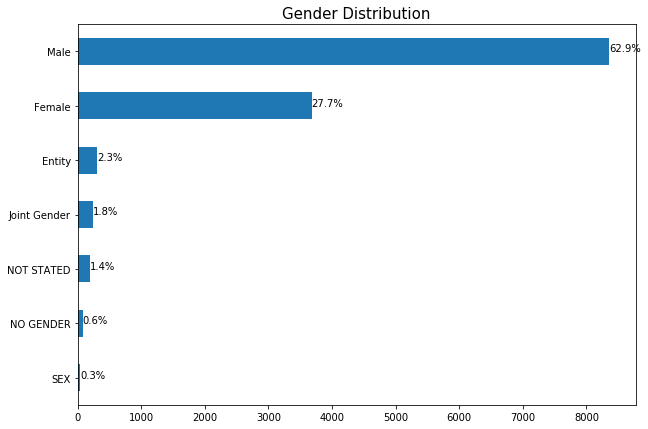

In [31]:
# Gender distribution 
ax = all_data.Gender.value_counts().sort_values().plot(kind = 'barh', figsize=(10,7))
plt.title('Gender Distribution', fontdict={'size': 15})
for p in ax.patches:
  percentage ='{:,.1f}%'.format((p.get_width()/all_data.shape[0])*100)
  width, height =p.get_width(),p.get_height()
  x=p.get_x()+width+0.02
  y=p.get_y()+height/2
  ax.annotate(percentage,(x,y))

In [32]:
mapper = {'Entity':'Other', 'Joint Gender':'Other', 'NOT STATED':'Other', 'NO GENDER': 'Other', 'SEX':"Other"}
all_data.Gender = all_data.Gender.replace(mapper)

# Confirm mappings
all_data.Gender.value_counts()

Male      8356
Female    3679
Other      846
Name: Gender, dtype: int64

In [33]:
# Check unique values for each categorical column
for col in cat_cols:
  print(col)
  print(all_data[col].unique(), '\n')


Gender
['Male' 'Female' 'Other' nan] 

Car_Category
[Saloon, JEEP, NaN, Motorcycle, Truck, ..., Wagon, Shape Of Vehicle Chasis, Sedan, Station 4 Wheel, Tipper Truck]
Length: 17
Categories (16, object): [Saloon, JEEP, Motorcycle, Truck, ..., Shape Of Vehicle Chasis, Sedan, Station 4 Wheel, Tipper Truck] 

Subject_Car_Colour
[Black, Grey, Red, NaN, As Attached, ..., Yellow & White, Beige Mitalic, Light Gray, Blue Sky, Red Maroon]
Length: 47
Categories (46, object): [Black, Grey, Red, As Attached, ..., Beige Mitalic, Light Gray, Blue Sky, Red Maroon] 

Subject_Car_Make
[TOYOTA, NaN, REXTON, Lexus, Hyundai, ..., BRILLIANCE, Buik, COMMANDER, Bajaj, Datsun]
Length: 76
Categories (75, object): [TOYOTA, REXTON, Lexus, Hyundai, ..., Buik, COMMANDER, Bajaj, Datsun] 

LGA_Name
[NaN, Lagos, Ikeja, Badagry, Eti-Osa, ..., Hong, Ifako-Agege, Benue, Okpokwu, Ngor-Okpala]
Length: 271
Categories (270, object): [Lagos, Ikeja, Badagry, Eti-Osa, ..., Ifako-Agege, Benue, Okpokwu, Ngor-Okpala] 

State
[NaN, 

In [59]:
def create_extra_features(data):
    data['PolicyLengthDays'] = (pd.to_datetime(data['Policy End Date'], format = '%Y-%m-%d') - 
                         pd.to_datetime(data['Policy Start Date'], format = '%Y-%m-%d')) / np.timedelta64(1, 'D')

In [60]:
create_extra_features(all_data)

In [61]:
all_data.head()

,Age,First Transaction Date,ID,No_Pol,Policy End Date,Policy Start Date,target,PolicyLengthDays,Policy Start Dateyear,Policy Start Datemonth,...,State_Warri-South,ProductName_CVTP,ProductName_Car Classic,ProductName_Car Plus,ProductName_Car Vintage,ProductName_CarFlex,ProductName_CarSafe,ProductName_Customized Motor,ProductName_Motor Cycle,ProductName_Muuve
0,30.0,2010-05-14,ID_0040R73,1,2011-05-13,2010-05-14,0.0,364.0,2010,5,...,0,0,1,0,0,0,0,0,0,0
1,79.0,2010-11-29,ID_0046BNK,1,2011-11-28,2010-11-29,1.0,364.0,2010,11,...,0,0,1,0,0,0,0,0,0,0
2,43.0,2010-03-21,ID_005QMC3,1,2011-03-20,2010-03-21,0.0,364.0,2010,3,...,0,0,1,0,0,0,0,0,0,0
3,42.0,2010-08-21,ID_0079OHW,1,2011-08-20,2010-08-21,0.0,364.0,2010,8,...,0,0,0,0,0,0,1,0,0,0
4,20.0,2010-08-29,ID_00BRP63,3,2010-12-31,2010-08-29,1.0,124.0,2010,8,...,0,0,0,0,0,0,0,0,0,1


In [62]:
all_data.loc[(all_data['Age'] > 90) |(all_data['Age'] < 18), 'Age'] = all_data['Age'].mode()

In [63]:
from verstack import NaNImputer
imputer = NaNImputer()

In [64]:
for col in all_data.columns:
  if col in date_cols+cat_cols:
    all_data[col] = all_data[col].fillna(all_data[col].mode()[0])
  elif col in num_cols:
    all_data[col] = all_data[col].fillna(all_data[col].mean())

# Confirm that there aren't any missing values
all_data[all_data.columns.difference(['target'])].isna().sum()


Age                               0
Car_Category_Bus                  0
Car_Category_CAMRY CAR HIRE       0
Car_Category_JEEP                 0
Car_Category_Mini Bus             0
                                 ..
Subject_Car_Make_Volkswagen       0
Subject_Car_Make_Volvo            0
Subject_Car_Make_Wrangler Jeep    0
Subject_Car_Make_Yamaha           0
Subject_Car_Make_ZOYTE            0
Length: 548, dtype: int64

In [ ]:
plt.figure(figsize=(20,10))
sns.heatmap(all_data.corr(), annot=True)

In [57]:
# Extract date features from the date columns
for col in date_cols:
  for date_feature in ['year', 'month', 'day']:
    all_data[col+date_feature] = getattr(all_data[col].dt, date_feature)

all_data.head()

,Age,First Transaction Date,ID,No_Pol,Policy End Date,Policy Start Date,target,PolicyLengthDays,Policy Start Dateyear,Policy Start Datemonth,...,State_Warri-South,ProductName_CVTP,ProductName_Car Classic,ProductName_Car Plus,ProductName_Car Vintage,ProductName_CarFlex,ProductName_CarSafe,ProductName_Customized Motor,ProductName_Motor Cycle,ProductName_Muuve
0,30.0,2010-05-14,ID_0040R73,1,2011-05-13,2010-05-14,0.0,364.0,2010,5,...,0,0,1,0,0,0,0,0,0,0
1,79.0,2010-11-29,ID_0046BNK,1,2011-11-28,2010-11-29,1.0,364.0,2010,11,...,0,0,1,0,0,0,0,0,0,0
2,43.0,2010-03-21,ID_005QMC3,1,2011-03-20,2010-03-21,0.0,364.0,2010,3,...,0,0,1,0,0,0,0,0,0,0
3,42.0,2010-08-21,ID_0079OHW,1,2011-08-20,2010-08-21,0.0,364.0,2010,8,...,0,0,0,0,0,0,1,0,0,0
4,20.0,2010-08-29,ID_00BRP63,3,2010-12-31,2010-08-29,1.0,124.0,2010,8,...,0,0,0,0,0,0,0,0,0,1


In [ ]:
all_data = pd.get_dummies(data = all_data, columns = cat_cols)
all_data.head()

In [42]:
# Separate train and test data from the combined dataframe
train_df = all_data[:ntrain]
test_df = all_data[ntrain:]

# Check the shapes of the split dataset
train_df.shape, test_df.shape

((12079, 549), (1202, 549))

In [43]:
main_cols = all_data.columns.difference(date_cols+['ID', 'target'])
X = train_df[main_cols]
y = train_df.target

In [44]:
# Convert data into Dmatrix
data_dmatrix = xgb.DMatrix(data=X,label=y)

In [22]:
# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.28, random_state=42)

# XGBRegressor Without GridearchCV

In [33]:
Xgboost_Model40 = xgb.XGBClassifier(learning_rate=0.3,
                                     n_estimators=1000,
                                     max_depth=8,
                                     min_child_weight=8,
                                     gamma=0,
                                     subsample=0.8,
                                     colsample_bytree=0.8,
                                     objective= 'binary:logistic',
                                     nthread=4,
                                     scale_pos_weight=1,
                                     seed=27)            

In [ ]:
Xgboost_Model40 = Xgboost_Model40.fit(X, y)

In [31]:
Xgboost_Model40.score(X_test,y_test)

0.943836831214898

In [305]:
test_df = test_df[main_cols]
Xgbpredictions40 = Xgboost_Model40.predict(test_df)

In [306]:
Xgbpredictions40 = Xgbpredictions40.astype(int)

In [307]:
Xgbpredictions40 = pd.DataFrame({'ID':test['ID'],'target': Xgbpredictions40})

In [308]:
Xgbpredictions40.to_csv("40XgbInsuranceAutoClaim.csv", index=False)